In [12]:
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

# Load Raw Data

Reading EGI MFF Header from /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/mdd_dlpfc/subject9_m191_dlpfc_58/m191_dlpfc_day1/m191_dlpfc_day1_treatment_20230424_021417.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
Reading 0 ... 720329  =      0.000 ...   720.329 secs...
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


/Users/Bella/mambaforge/envs/clean/lib/python3.12/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Bella/mambaforge/envs/clean/lib/python3.12/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


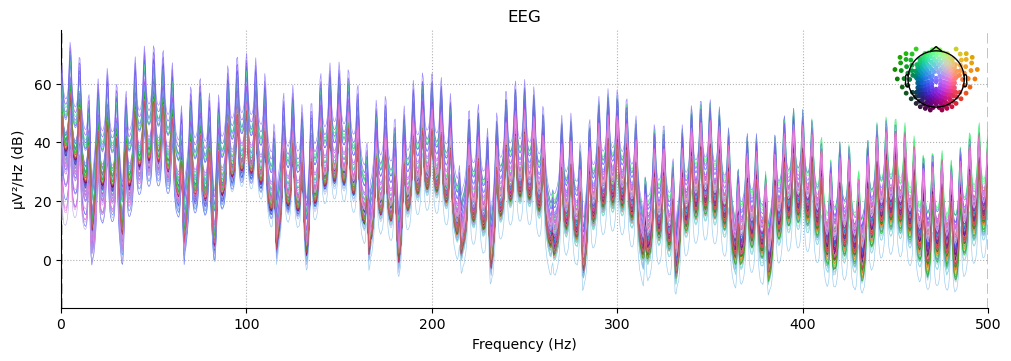

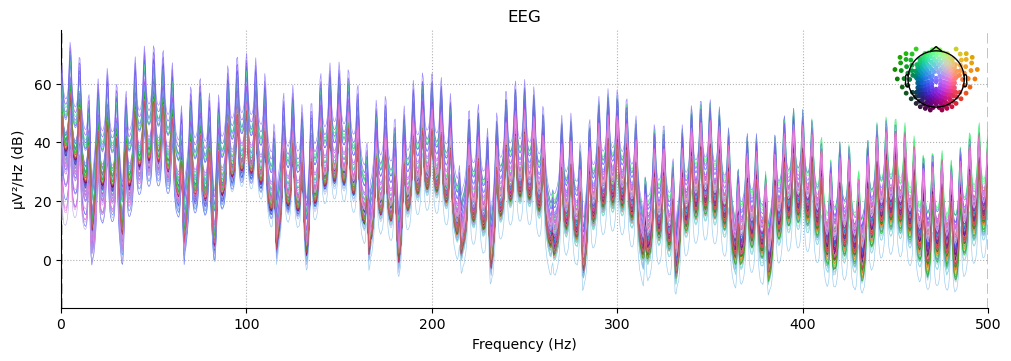

In [13]:
# Specify treatment raw file path
data_path = '/Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/mdd_dlpfc/'

data_folder = data_path+'subject9_m191_dlpfc_58/m191_dlpfc_day1/'
filename = 'm191_dlpfc_day1_treatment_20230424_021417.mff'
treatment_file_raw = os.path.join(data_folder, filename)
treatment_raw = mne.io.read_raw_egi(treatment_file_raw, preload=True)

def notch_and_hp(raw, notch_freqs, notch_widths, l_freq=1.0, h_freq=None, filter_type='fir'):
    notch_freqs = np.array(notch_freqs)
    notch_widths = np.asarray(notch_widths)
    raw_notch = raw.copy().notch_filter(freqs=notch_freqs, notch_widths=None, verbose='warning')
    raw_hp = raw_notch.filter(l_freq=l_freq, h_freq=h_freq, method=filter_type, verbose='warning')
    return raw_hp

notch_freqs = [60,120,180,240,300,360,400,420,460,480]
notch_widths = None

treatment_raw.info['bads'] = ['VREF']
#treatment_filt = notch_and_hp(treatment_raw, l_freq=1.0, notch_freqs=notch_freqs, notch_widths=notch_widths)
treatment_filt = treatment_raw.filter(l_freq=0.1, h_freq=None, method='fir', verbose='warning')
#treatment_notch.info['bads'] = ['VREF']

fig = treatment_raw.compute_psd().plot(show=True, exclude='bads')
sns.despine()

fig = treatment_filt.compute_psd().plot(show=True, exclude='bads')
sns.despine()

#treatment_filt.resample(200.0)



### Plot Spectra and Epoch data

In [14]:
# Read DIN1 events for TMS data
treatment_filt.info
treatment_events = mne.find_events(treatment_filt, stim_channel = 'DIN1')

600 events found on stim channel DIN1
Event IDs: [1]


Effective window size : 2.048 (s)


/Users/Bella/mambaforge/envs/clean/lib/python3.12/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Bella/mambaforge/envs/clean/lib/python3.12/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


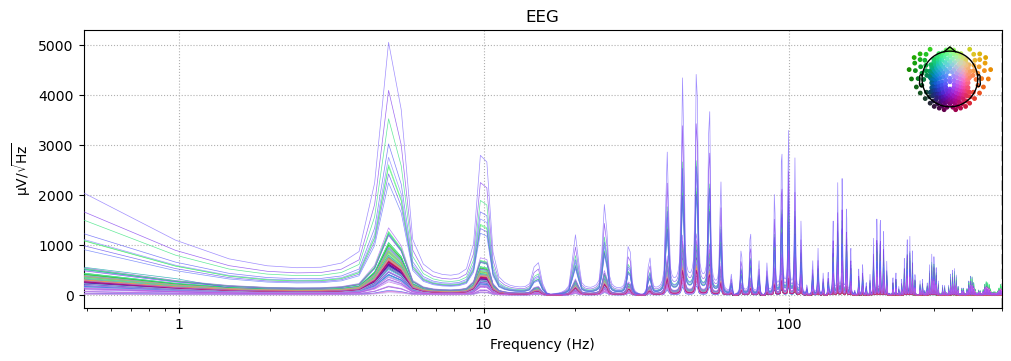

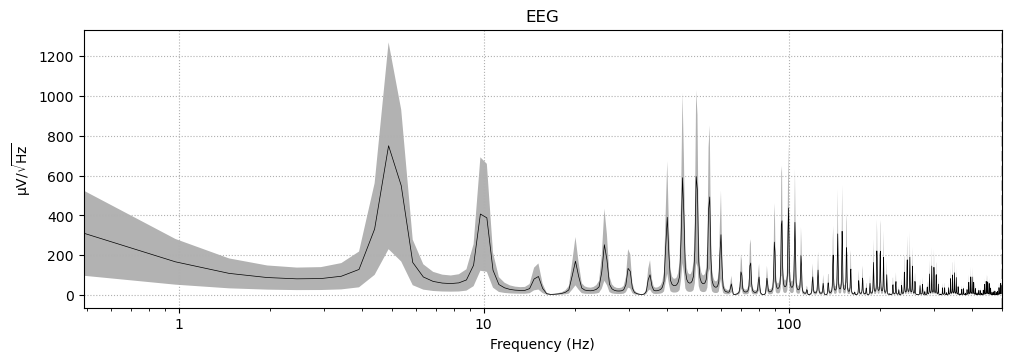

In [15]:
spectrum = treatment_filt.compute_psd()
for average in (False, True):
    spectrum.plot(average=average, dB=False, xscale="log", picks="data", exclude="bads")

In [16]:
# Create Epochs
epochs = mne.Epochs(treatment_filt, treatment_events, tmin=-0.1, tmax=0.1, baseline=(0, 0), preload=True)
print(epochs)  # 600 epochs created for Event ID '1'

Not setting metadata
600 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 600 events and 201 original time points ...
0 bad epochs dropped
<Epochs |  600 events (all good), -0.1 – 0.1 s, baseline 0 – 0 s, ~238.6 MB, data loaded,
 '1': 600>


Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


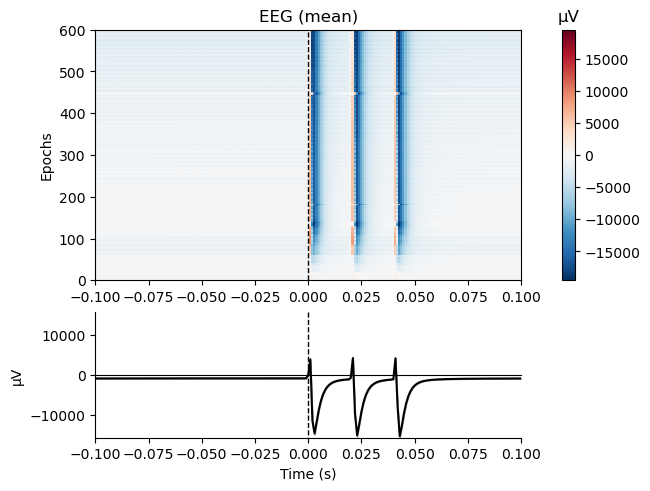

Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
combining channels using "<function get_epoch_sd at 0x164db5080>"


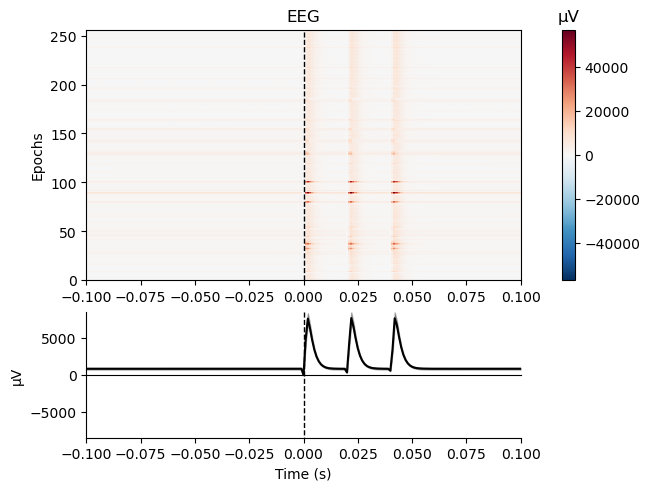

[<Figure size 640x480 with 3 Axes>]

In [17]:
epochs.plot_image(combine="mean")

def get_epoch_sd(epochs):
    return np.std(epochs,axis=0)

epochs.plot_image(combine=get_epoch_sd)



Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated


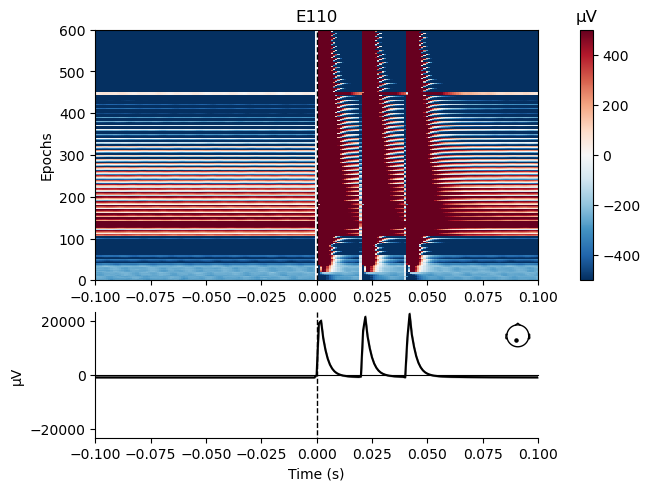

In [18]:
fig = epochs.plot_image(picks=['E110'], vmin=-500, vmax=500)


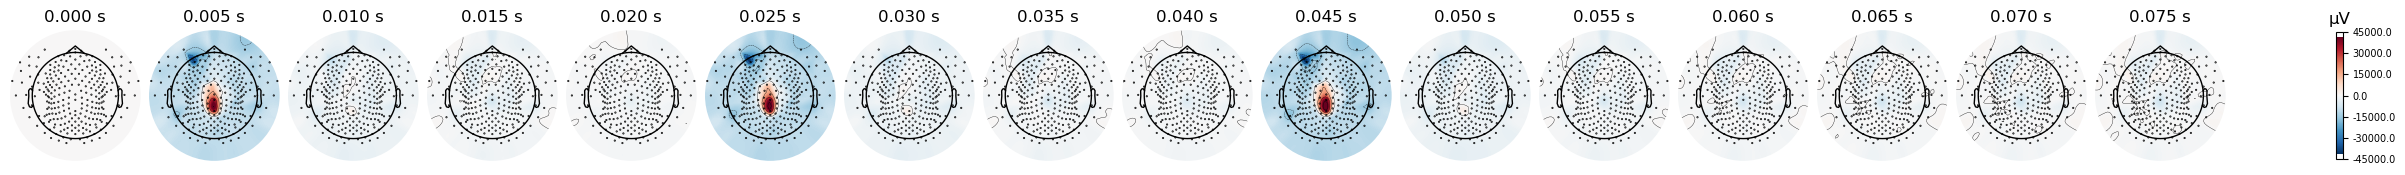

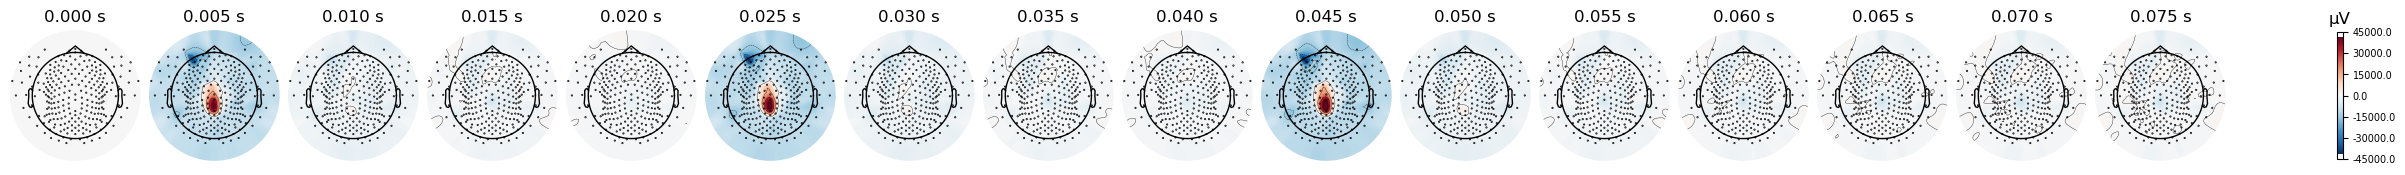

In [19]:
evoked = epochs.average()
evoked_se = epochs.standard_error()

times = np.arange(0.0, 0.08, 0.005)
evoked.plot_topomap(times)


### Find iTBS pulse onsets without DINs (using peak finding)

In [20]:
# from scipy.signal import find_peaks, find_peaks_cwt
# from scipy import signal

# def peak_find(data, fps=1000, method='wavelet', quantile_thresh=0.4, dist=0.25, prom_floor=1e-9, smooth_amount=0.5,
#               band_lower=0.02, band_upper=1.0, wavelet_widths=[32.0], wavelet_snr=6.0):
#     """
#     Arguments:
#     - data: data time series
#     - method: one of 'derivative', 'smooth', or 'wavelet'
#     - quantile_thresh: sets level of threshold peaks must be above (for 'derivative' and 'smooth' methods)
#     - dist: scales distance between peaks in units of frames per second (for 'derivative' and 'smooth' methods)
#     - prom_floor: sets floor for prominence of peak threshold (for 'derivative' and 'smooth' methods)
#     - smooth_amount: amount of smoothing used in 'smooth' method
#     - band_lower: lower low pass band cutoff frequency (for 'derivative' method)
#     - band_upper: upper low pass band cutoff frequency (for 'derivative' method)
#     - wavelet_widths: width of wavelet(s) for 'wavelet' method
#     - wavelet_snr: SNR for 'wavelet' method threshold
#     Returns:
#     - peak_idx: indices for peaks discovered

#     """
#     if method == 'derivative':
#         # set low pass filters
#         lower = smooth_zerophase(data,amount = band_lower*(1.0/fps))
#         upper = smooth_zerophase(data,amount = band_upper*(1.0/fps))

#         # Get the smooth 2nd derivative of the squared difference between upper and lower low pass bands
#         sq_diff = (upper-lower)**3
#         neg_sm_2nd = -1*smooth_2nd_derivative(sq_diff,window_length=fps)

#         # Find the maximum absolute deviation threshold at 95% CI and resulting max peaks for neg. 2nd derivative
#         mad, thresh_idx = MAD_thresh(sq_diff+neg_sm_2nd,thresh=2.91)
#         peak_idx = find_peaks(sq_diff+neg_sm_2nd, height=mad, distance=dist*fp_data.fps, prominence=(prom_floor,np.inf))[0]

#     elif method == 'smooth':
#         peak_detrend = smooth_zerophase(data, amount = (dr*smooth_amount/fps))
#         peak_idx = find_peaks(peak_detrend, height=np.quantile(peak_detrend,[quantile_thresh])[0], distance=dist*fp_data.fps, prominence=(prom_floor,np.inf))[0]

#     elif method == 'wavelet':
#         peak_idx = find_peaks_cwt(data, widths=[w*fps for w in wavelet_widths], wavelet=signal.ricker, min_snr=wavelet_snr)
#     else:
#         raise ValueError('Specified method not available.')

#     return peak_idx

# def smooth_zerophase(x, amount = 0.05, order = 3):
#     '''
#     Smooths using a butterworth filter.  The filter is applied
#     twice with filtfilt, once forward and once backwards.  This
#     yield a zero phase (i.e. no lag) filter that is well suited
#     to filtering time series.

#     This is based directly on the filtfilt scipy recipe:

#     http://wiki.scipy.org/Cookbook/FiltFilt
#     Example:
#     angles_left_smooth = smooth_zerophase(angles_left, 0.001, 1)
#     angles_left_smoothed = angles_left - angles_left_smooth
#     '''
#     from scipy.signal import lfilter, lfilter_zi, filtfilt, butter

#     # Create an order 3 lowpass butterworth filter.
#     b, a = butter(order, amount)

#     # Apply the filter to xn.  Use lfilter_zi to choose the initial condition
#     # of the filter.
#     zi = lfilter_zi(b, a)
#     z, _ = lfilter(b, a, x, zi=zi*x[0])

#     # Apply the filter again, to have a result filtered at an order
#     # the same as filtfilt.
#     z2, _ = lfilter(b, a, z, zi=zi*z[0])

#     # Use filtfilt to apply the filter.
#     y = filtfilt(b, a, x, padlen=int(0.1*len(x)),padtype='odd')
#     return y

# def MAD_thresh(data, thresh=2.91):
#     MAD = np.median(np.abs(data - np.median(data)))
#     thresh_idx = np.where(data > MAD*thresh)[0]
#     return MAD, thresh_idx

# def smooth_2nd_derivative(x,window_length=51): #why was window_length originally =51 here? but is =fps above
#     return savgol_filter(x,window_length,polyorder=3,deriv=2,mode='nearest')


In [21]:
# from scipy.signal import savgol_filter
# epoch_data = epochs.get_data()

# tseries = np.squeeze(treatment_filt.pick(['E33']).get_data())

# def find_tms_onset(time_series, thresh=0.004):
#     time_series = savgol_filter(time_series,7,3,deriv=1)
#     return np.where(time_series>thresh)[0]

# peaks = peak_find(tseries)
# plt.plot(tseries)

# # for i in range(60):
# #     plt.figure(figsize=(20,2))
# #     vec = np.diff(np.mean(np.abs(epochs.pick(['E33']).get_data()),axis=1)[i*10,:])
# #     peaks = peak_find(vec)
# #     plt.axvline(x=peaks[0])
# #     plt.plot(vec)
# #     sns.despine()



### Modeling the artifact with tensor decomposition (Tucker)

In [ ]:
import tensorly as tl
from tensorly.decomposition import tucker, parafac

epoch_data = epochs.get_data()[:,0:257,:]
epoch_stim = epochs.get_data()[:,257:,:]

import time
tic = time.time()
tucker_decomp = tucker(epoch_data,60)
#cp_decomp = parafac(epoch_data,60)
print(time.time()-tic)


/var/folders/bf/tx13kltn043fzjw05wb4ck0w0000gn/T/ipykernel_74494/1327239256.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_data = epochs.get_data()[:,0:257,:]
/var/folders/bf/tx13kltn043fzjw05wb4ck0w0000gn/T/ipykernel_74494/1327239256.py:5: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_stim = epochs.get_data()[:,257:,:]
/Users/Bella/mambaforge/envs/clean/lib/python3.12/site-packages/tensorly/tucker_tensor.py:425: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


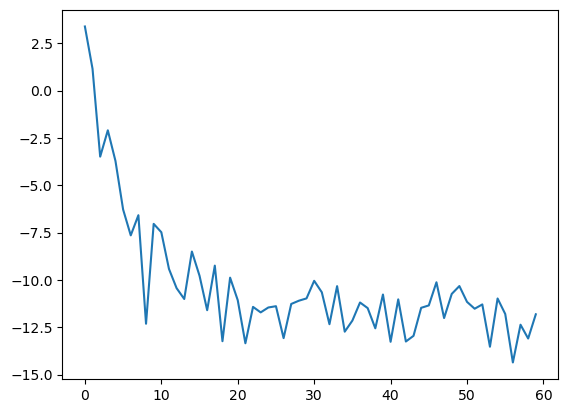

In [12]:
# Plot tensor equivalent of singular values (diagonal of core tensor)
def get_3dtensor_diag(tensor):
    diag = []
    for i in range(tensor.shape[0]):
        diag.append(tensor[i,i,i])
    return np.array(diag)
tucker_diag = get_3dtensor_diag(tucker_decomp.core)
plt.plot(np.log(np.abs(tucker_diag)))


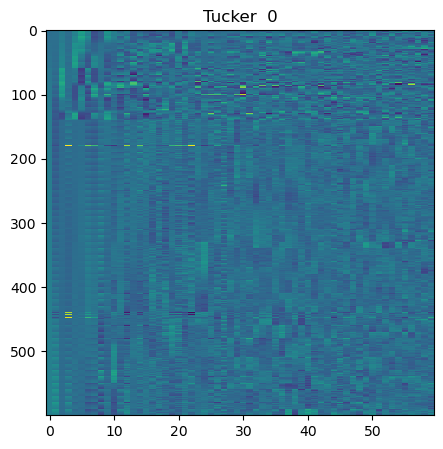

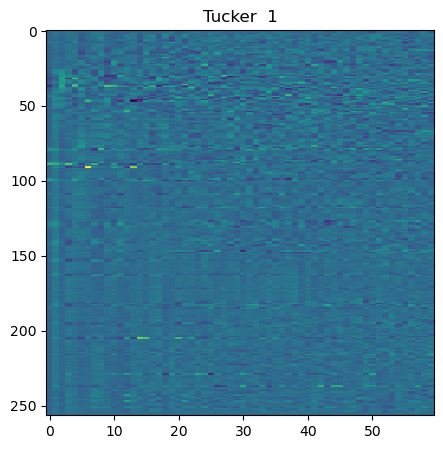

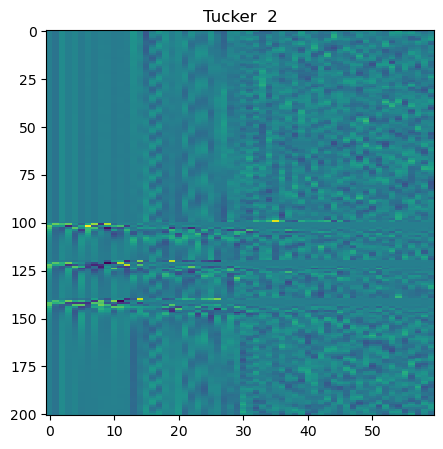

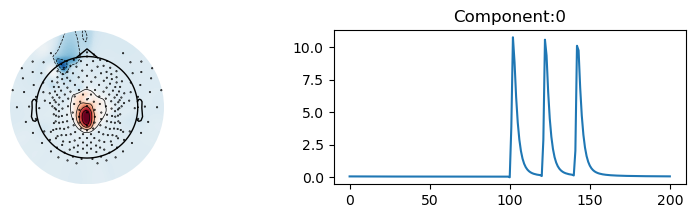

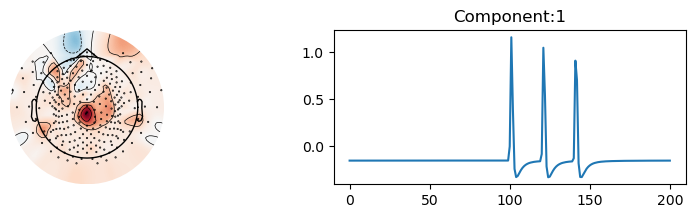

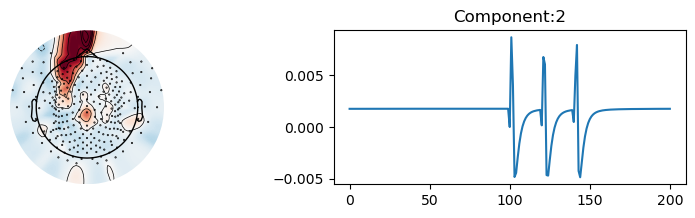

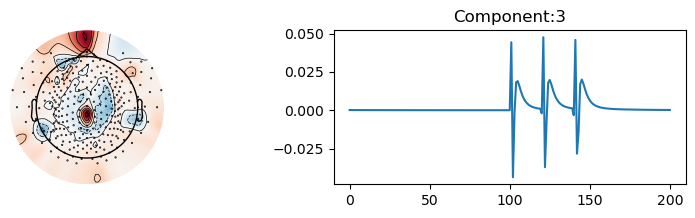

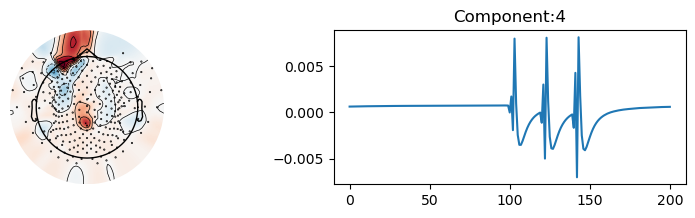

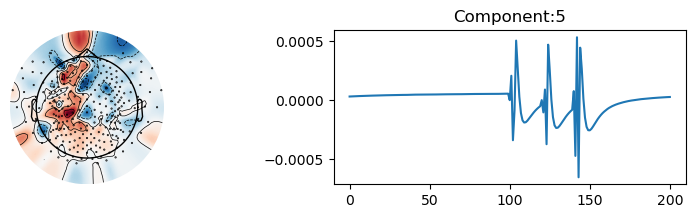

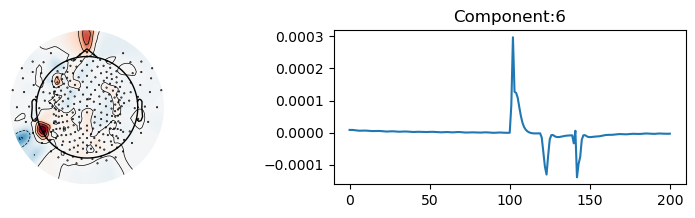

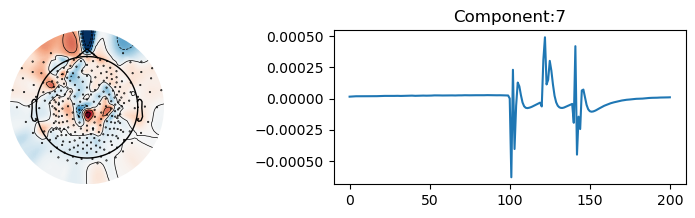

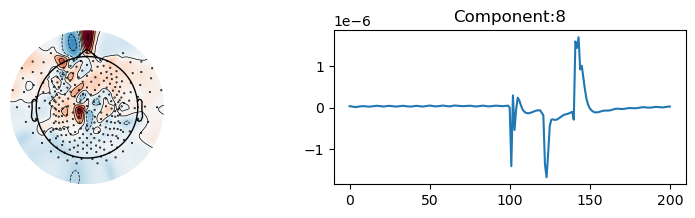

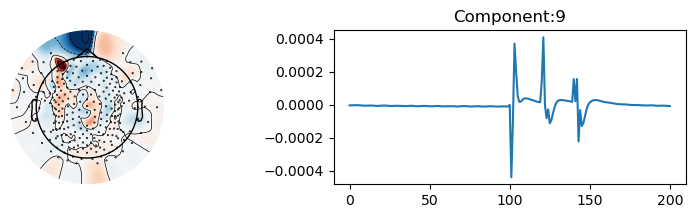

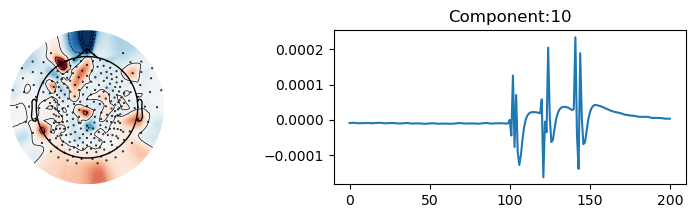

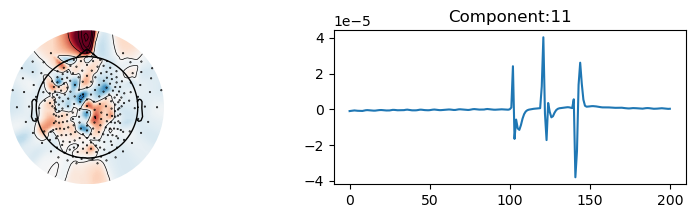

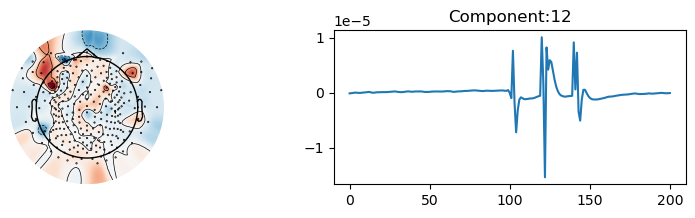

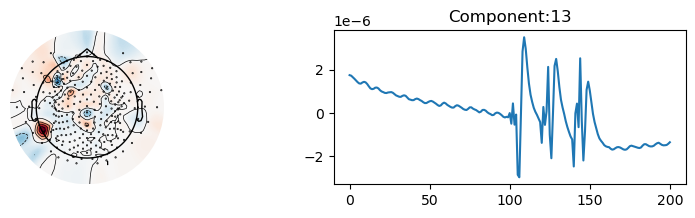

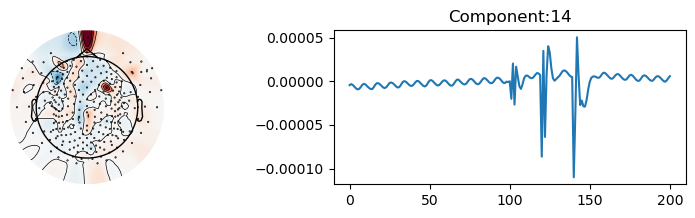

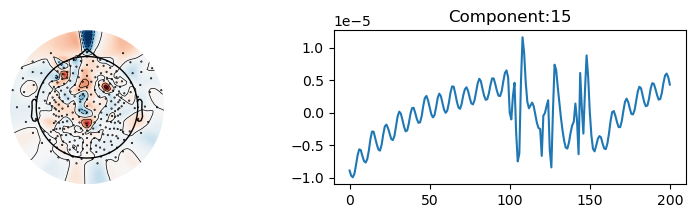

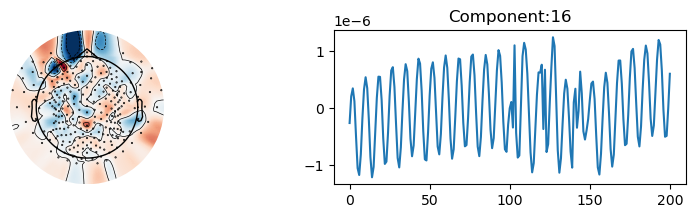

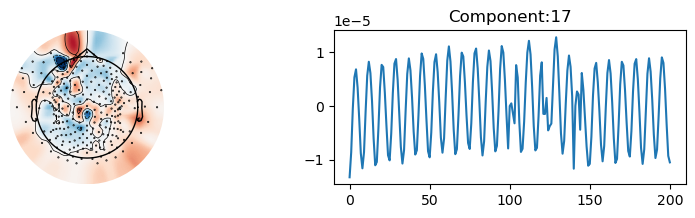

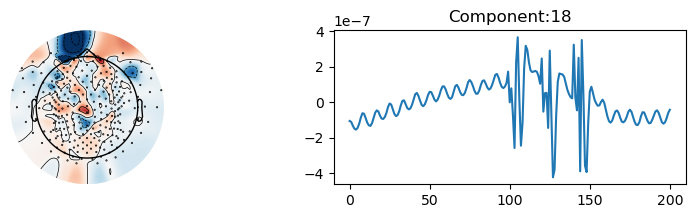

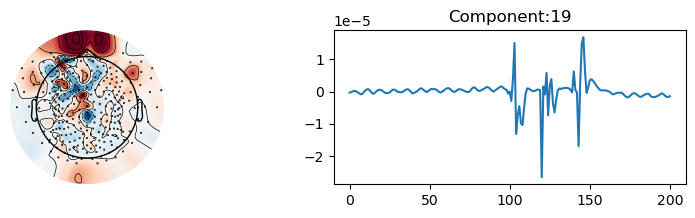

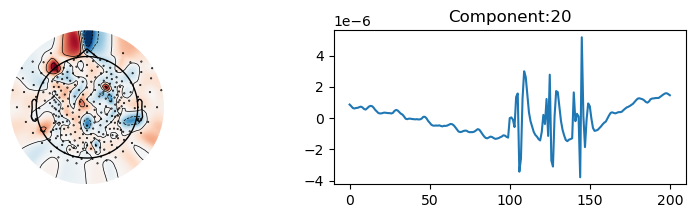

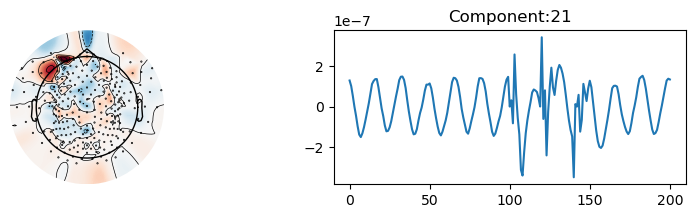

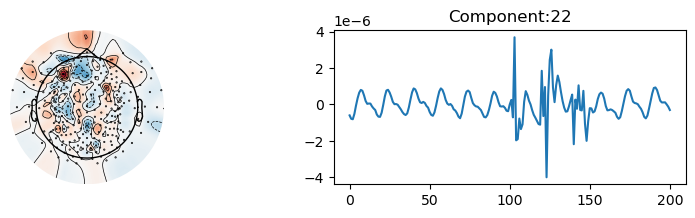

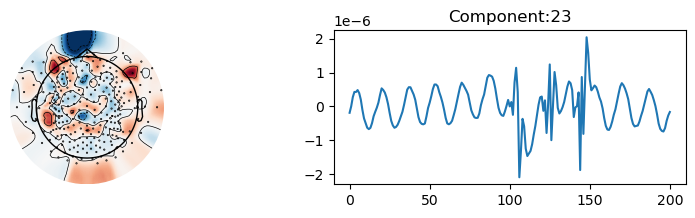

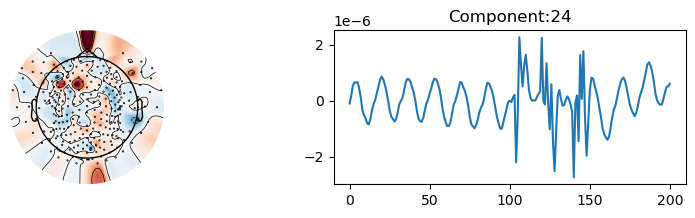

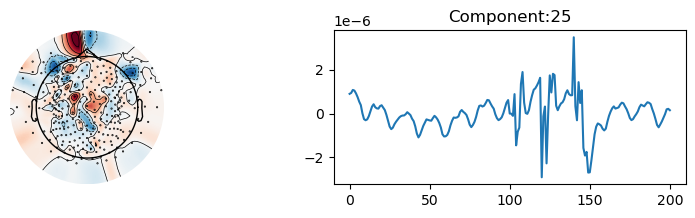

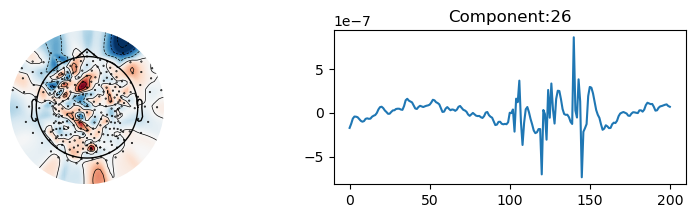

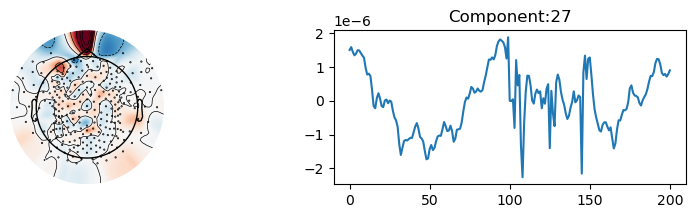

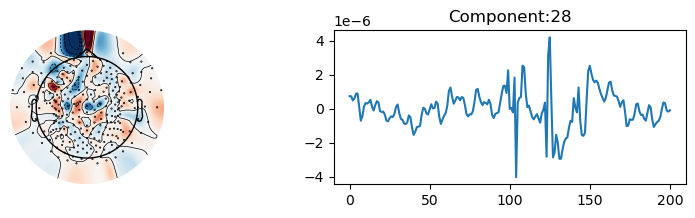

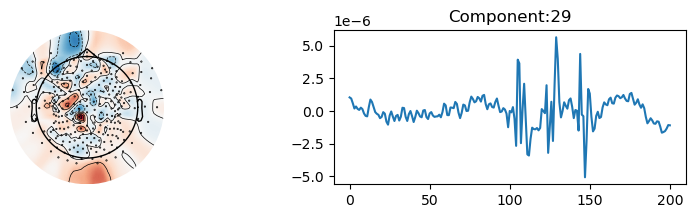

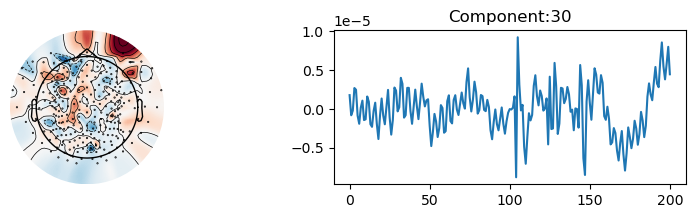

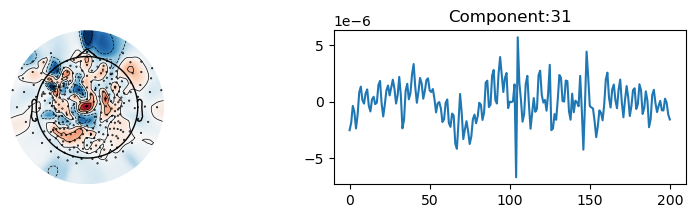

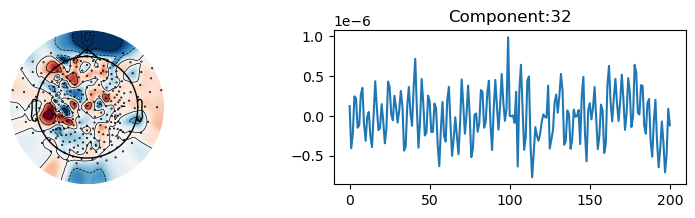

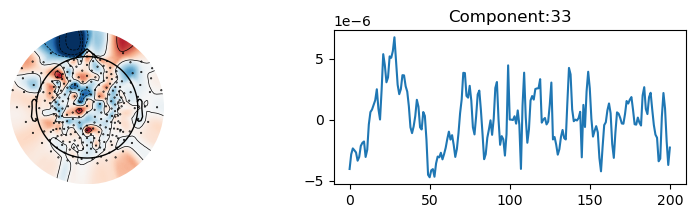

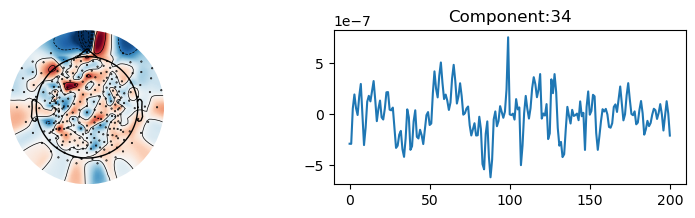

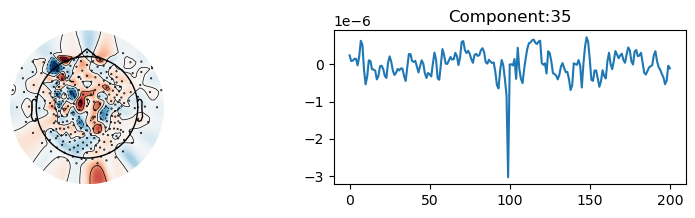

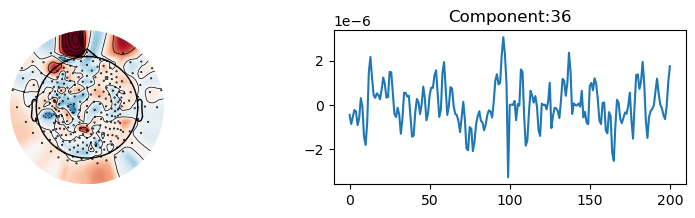

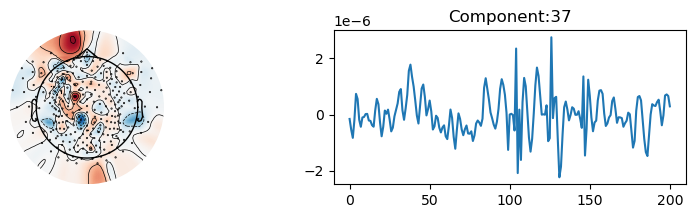

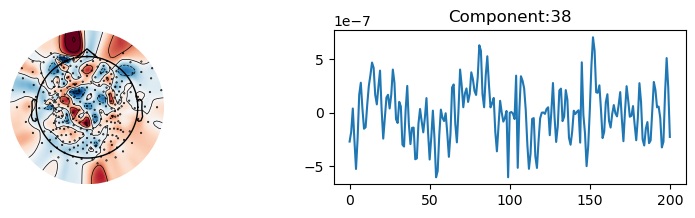

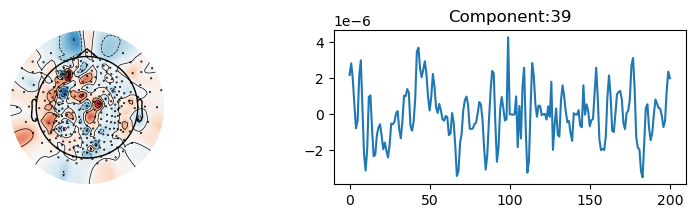

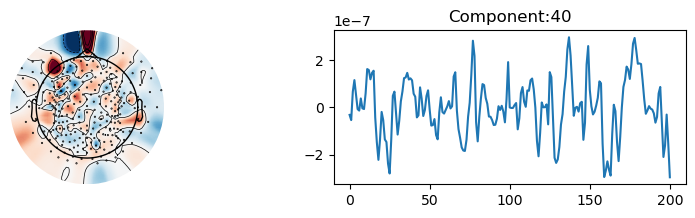

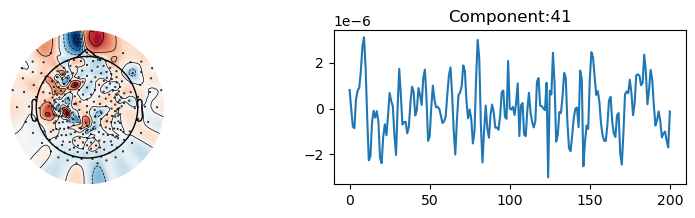

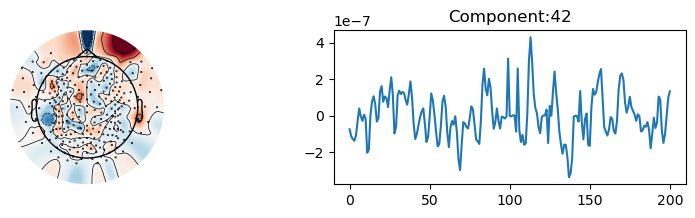

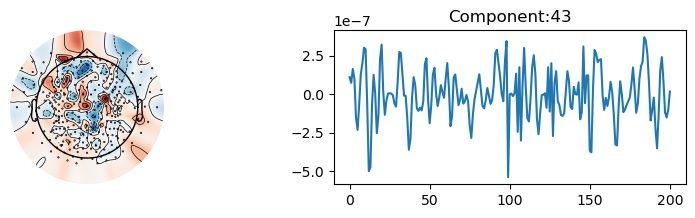

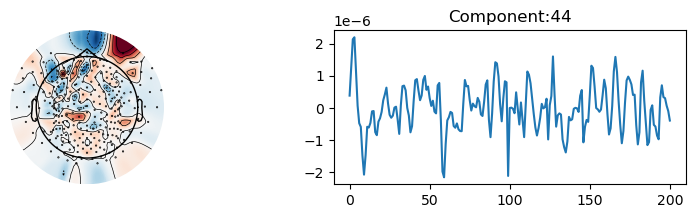

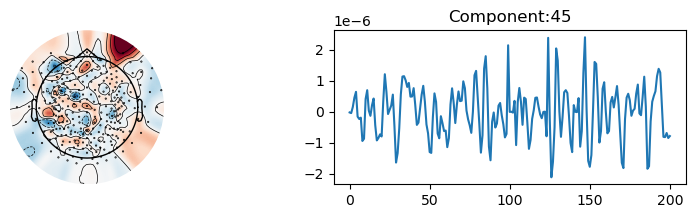

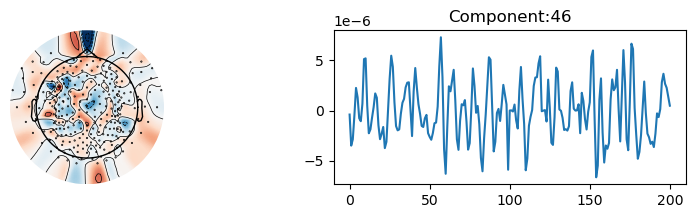

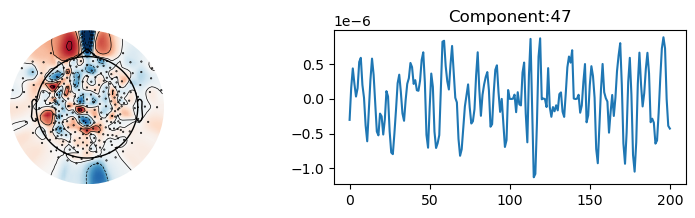

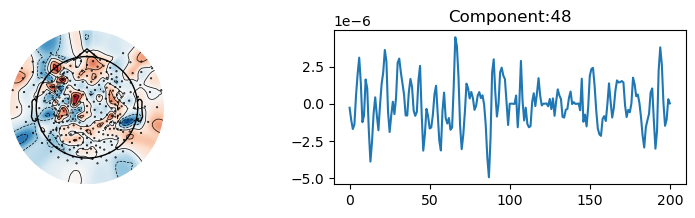

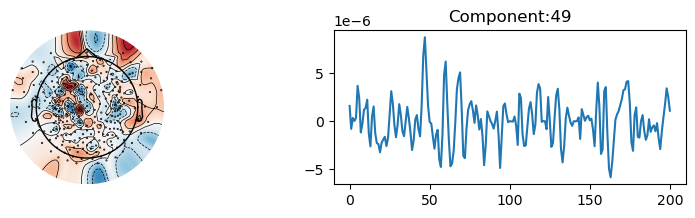

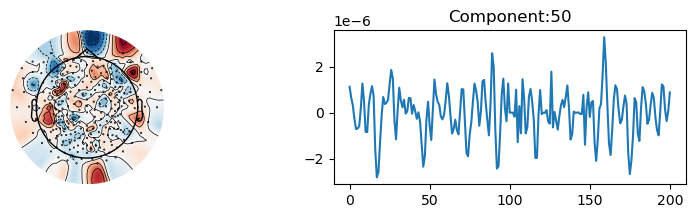

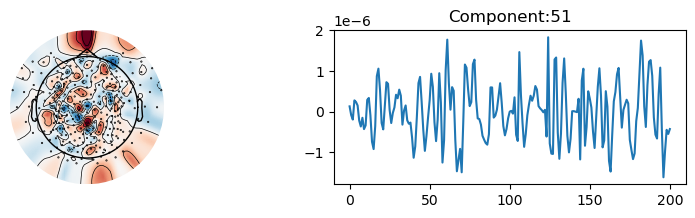

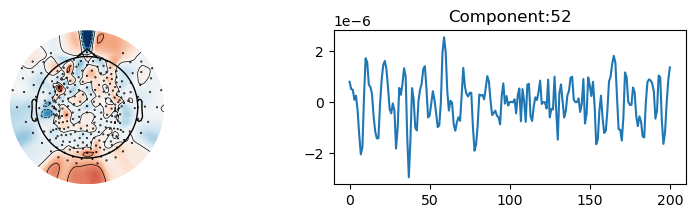

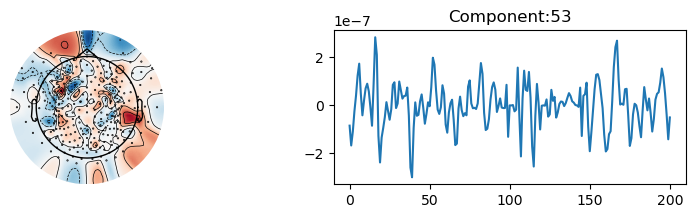

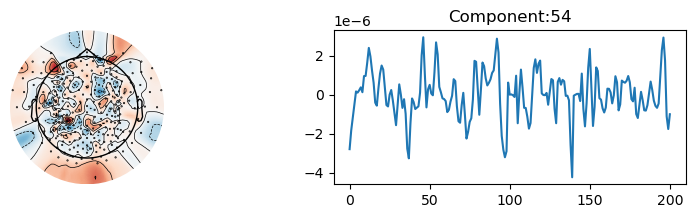

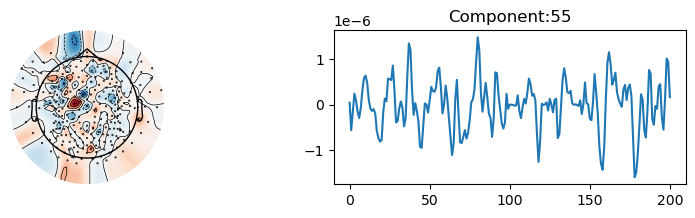

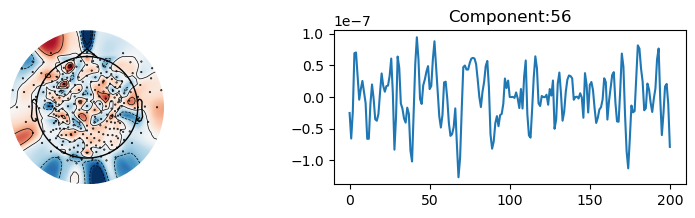

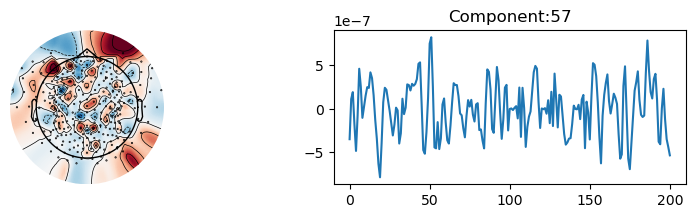

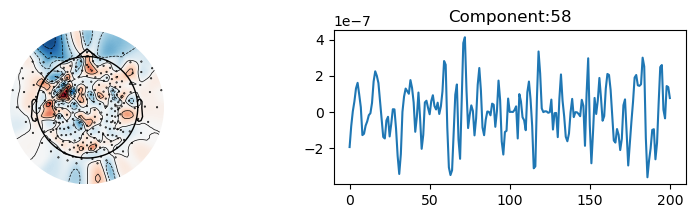

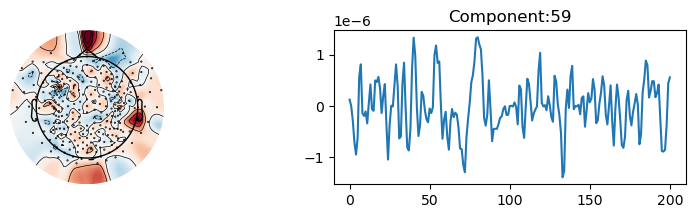

In [13]:
# for i in range(3):
#     plt.figure(figsize=(5,5))
#     plt.imshow(cp_decomp.factors[i],aspect='auto',interpolation='nearest')
#     plt.title("CP "+str(i))

# Plot images of 2D factors
for i in range(3):
    plt.figure(figsize=(5,5))
    plt.imshow(tucker_decomp.factors[i],aspect='auto',interpolation='nearest')
    plt.title("Tucker  "+str(i))

# Plot scalp maps and time series corresponding to tensor decomposition components
for i in range(60):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,2))
    ax2.plot(tucker_diag[i]*tucker_decomp.factors[2][:,i])
    ax2.set_title("Component:"+str(i))
    mne.viz.plot_topomap(tucker_decomp.factors[1][:,i], pos=treatment_raw.info, axes=ax1)



In [14]:
# Zero out first n components to try and remove artifact
tucker_decomp.factors[2][:,0:38] = 0.0


Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated


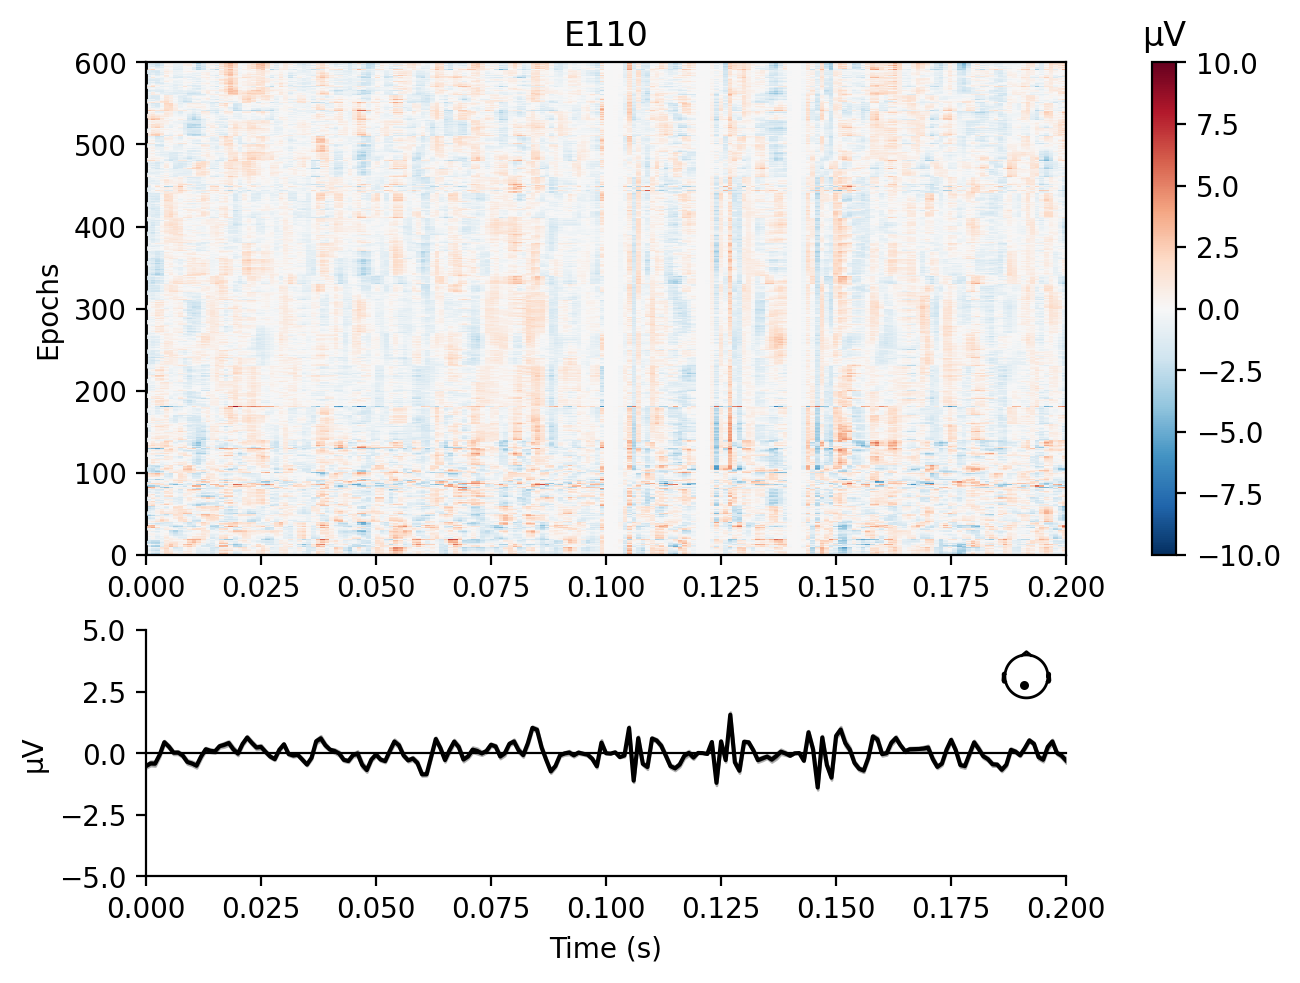

In [23]:
# Plot channel over epochs pre artifact removal
%matplotlib qt
fig = epochs.plot_image(picks=['E110'], vmin=-500, vmax=500)

# Plot channel over epochs post artifact removal
tensor_cleaned = tl.tucker_to_tensor(tucker_decomp)
tensor_cleaned = np.concatenate((tensor_cleaned,epoch_stim),axis=1)
epochs_cleaned = mne.EpochsArray(tensor_cleaned,epochs.info)
fig = epochs_cleaned.plot_image(picks=['E110'], vmin= -10, vmax= 10)
fig[0].axes[1].set_ylim([-5,5])
fig[0]

### Artifact removal with CEBRA

In [ ]:
from cebra import CEBRA

cebra_time_model = CEBRA(model_architecture='offset10-model',
                        batch_size=1024,
                        learning_rate=3e-4,
                        temperature=1.0,
                        output_dimension=250,
                        max_iterations=10000,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=500)
cebra_time_model.fit(treatment_raw.get_data().T)
#cebra_time_model.save("cebra_time_model.pt")

In [ ]:
import cebra
ax1 = plt.subplot(111, projection='3d')
cebra_time = cebra_time_model.transform(treatment_raw.get_data().T)
cebra.plot_embedding(ax=ax1, embedding=cebra_time, title='CEBRA-Time') #, cmap=cmap)


In [ ]:
plt.figure(figsize=(10,2))
for component_num in range(0,250,80):
    plt.figure(figsize=(10,2))
    plt.plot(cebra_time[105000:105500,component_num])
    plt.title("CEBRA Component: "+str(component_num))
    plt.xlabel("Time Samples (1000 Hz)")
    plt.ylabel("A.U.")
    sns.despine()


### Modeling the artifact with ICA

In [ ]:
from sklearn.decomposition import FastICA
import scipy
import pywt
def wICA(ica, ICs, levels=7, wavelet='coif5', normalize=False, 
         trim_approx=False, thresholding='soft', verbose=True):
    '''
    Wavelet ICA thresholding. 
    Args:
        ica: fitted ica object (currently only works with Sklearn's FastICA). TODO: add MNE options.
        ICs: a numpy array of independent components with shape: (#time points, #components).
        levels: number of wavelet levels.
        wavelet: wavelet to use, defaults to Coiflet 5.
        normalize: boolean, see pywt.swt documentation
        trim_approx: boolean, see pywt.swt documentation
        thresholding: 'hard' or 'soft',  should wavelet thresholding use a hard or soft threshold.
        verbose: boolean flag for verbose printing.
    Returns:
        wICs: the wavelet thresholded ICs, leaving only large amplitude effects.
        artifacts: the wICs ICA inverse transformed back to ambient data space, shape: (#time points, #channels). 
    '''
    # Pad out the data to the correct length for wavelet thresholding
    modulus = np.mod(ICs.shape[0],2**levels)
    if modulus !=0:
        extra = np.zeros((2**levels)-modulus)
    if verbose:
        print('  Data padded with ', str(len(extra)), ' additional values.')
        print('  Wavelet thresholding with wavelet:', wavelet)
    wavelet = pywt.Wavelet(wavelet)

    # Iterate over independent components, thresholding each one using a stationary wavelet transform
    # with soft thresholding. 
    print('  Fitting ICA for wavelet-ICA cleaning...')
    wICs = []
    for i in range(ICs.shape[1]):
        if verbose:
            print("  Thresholding IC#",i)
        sig = np.concatenate((ICs[:,i],extra))
        thresh = ddencmp(sig, wavelet)
        swc = pywt.swt(sig, wavelet, level=levels, start_level=0, trim_approx=trim_approx, norm=normalize)
        y = pywt.threshold(swc, thresh, mode=thresholding, substitute=0)
        wICs.append(pywt.iswt(y, wavelet, norm=normalize))
    wICs = np.asarray(wICs)[:,0:ICs.shape[0]].T
    
    print("  Computing cleaned inverse transform...")
    artifacts = ica.inverse_transform(ICs)

    #artifacts = np.dot(ICs, ica.mixing_.T)

    #mean_tol = 1e-6
    #if ica.whiten:
    #    for i, mean in enumerate(ica.mean_):
    #        print("  adding back mean ", str(i))
    #        if np.abs(mean) > mean_tol:
    #            artifacts[:,i] = artifacts[:,i] + mean

    return wICs, artifacts

def ddencmp(x, wavelet='db1', scale=2.0):
    '''
    Python recreation of MATLAB's ddencmp function for choosing wavelet threshold using 
    Donoho and Johnstone universal threshold scaled by a robust variance estimate.
    Arg 'scale' allows adjusting the threshold more manually.

    '''
    n = len(x)
    (cA, cD)  = pywt.dwt(x,wavelet)
    noiselev = np.median(np.abs(cD))/0.6745
    thresh = np.sqrt(2*np.log(len(x)))*noiselev*scale
    return thresh

ica = FastICA(n_components=250, whiten="arbitrary-variance")
ica.fit(treatment_raw.get_data().T)  
ICs = ica.fit_transform(treatment_raw.get_data().T)
wICs, artifacts = wICA(ica, ICs)


In [ ]:
cleaned = treatment_filt.get_data() - artifacts.T
cleaned.min(), cleaned.max()

In [ ]:
cleaned = treatment_filt.get_data() - artifacts.T

wICA_artifact_raw = mne.io.RawArray(artifacts.T,treatment_filt.info)
wICA_artifact_epochs = mne.Epochs(wICA_artifact_raw, treatment_events, tmin=-0.1, tmax=0.1, baseline=(0, 0))
fig = wICA_artifact_epochs.plot_image(picks=['E110'], vmin=-500, vmax=500)


In [ ]:
wICA_cleaned_raw = mne.io.RawArray(cleaned, treatment_raw.info)
wICA_cleaned_epochs = mne.Epochs(wICA_cleaned_raw, treatment_events, tmin=-0.1, tmax=0.1, baseline=(0, 0))
fig = wICA_cleaned_epochs.plot_image(picks=['E110'])

In [ ]:
plt.figure(figsize=(10,2))
for component_num in range(0,250,80):
    plt.figure(figsize=(10,2))
    plt.plot(ICs[105000:105500,component_num])
    plt.title("ICA Component: "+str(component_num))
    plt.xlabel("Time Samples (1000 Hz)")
    plt.ylabel("A.U.")
    sns.despine()